generation biomass: 87 outliers detected
generation fossil gas: 2185 outliers detected
generation fossil oil: 246 outliers detected
generation hydro pumped storage consumption: 3762 outliers detected
generation hydro water reservoir: 343 outliers detected
generation nuclear: 74 outliers detected
generation other: 1267 outliers detected
generation other renewable: 5 outliers detected
generation waste: 328 outliers detected
generation wind onshore: 379 outliers detected
forecast wind onshore day ahead: 436 outliers detected
price day ahead: 841 outliers detected
price actual: 699 outliers detected


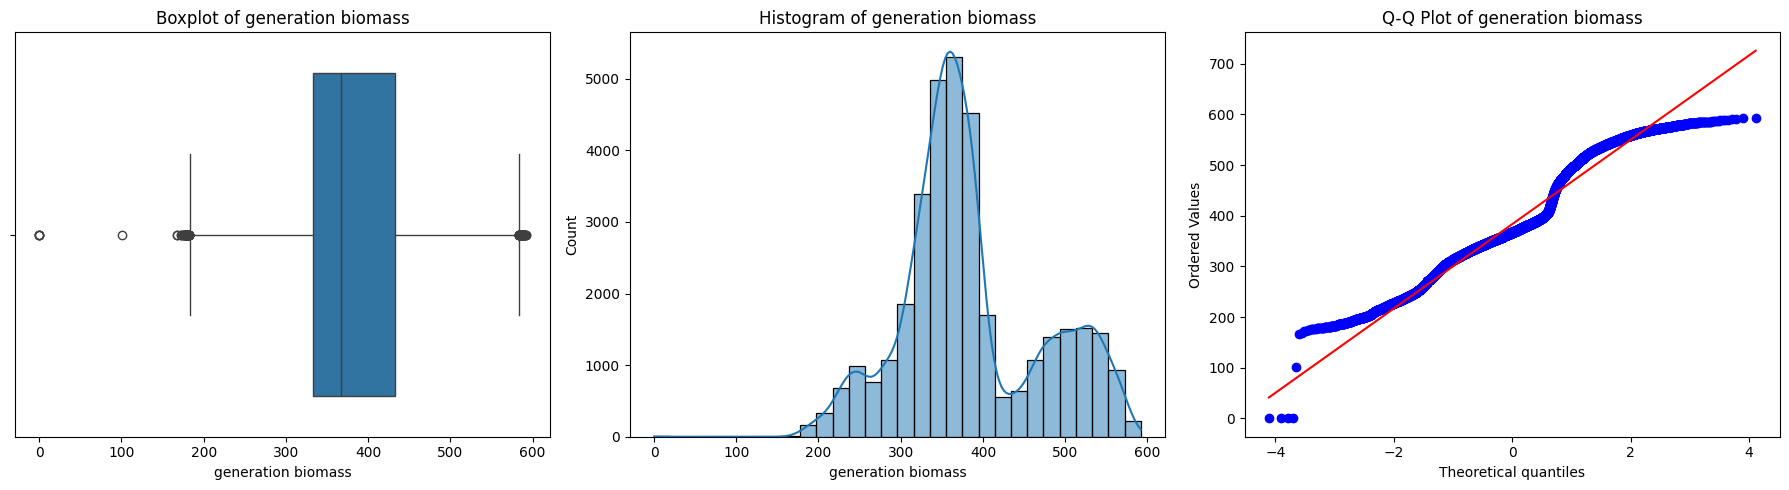

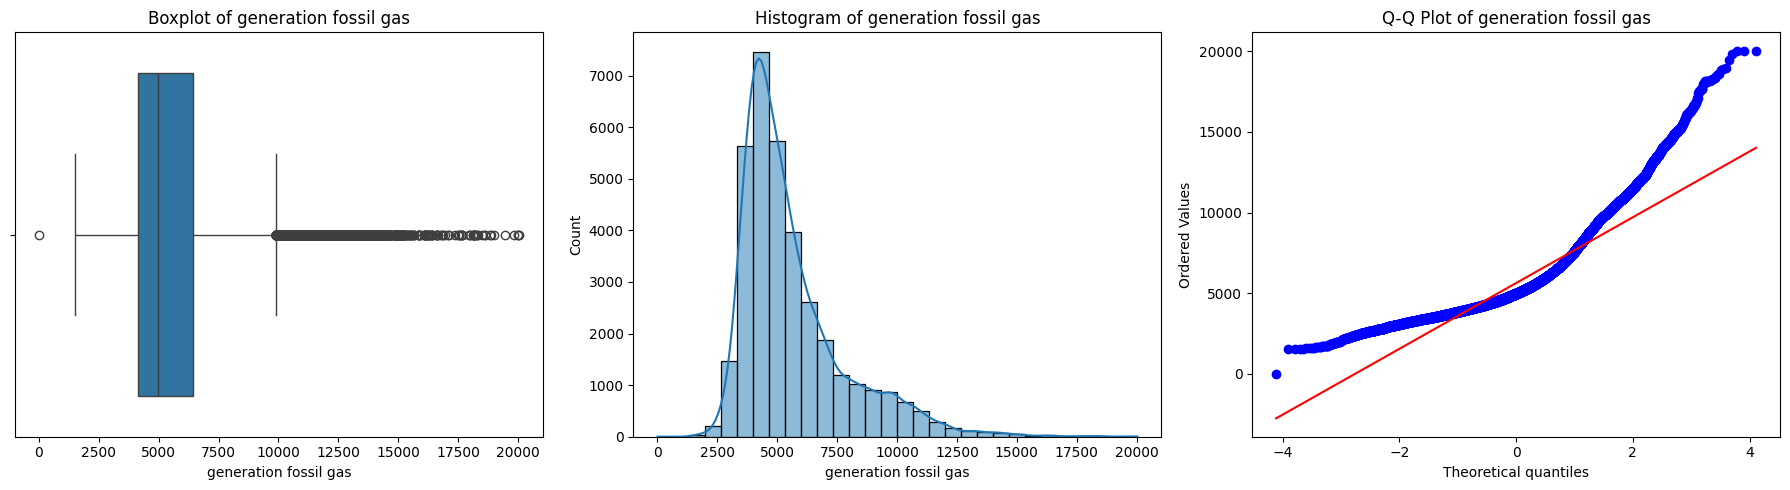

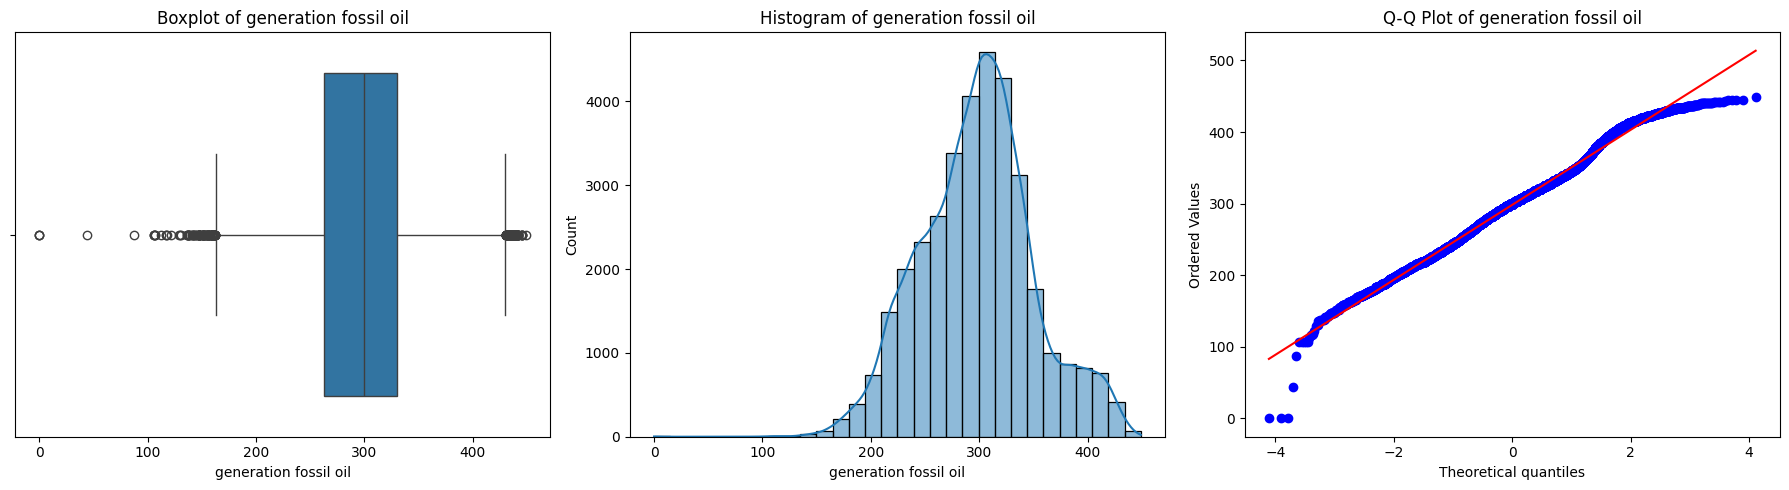

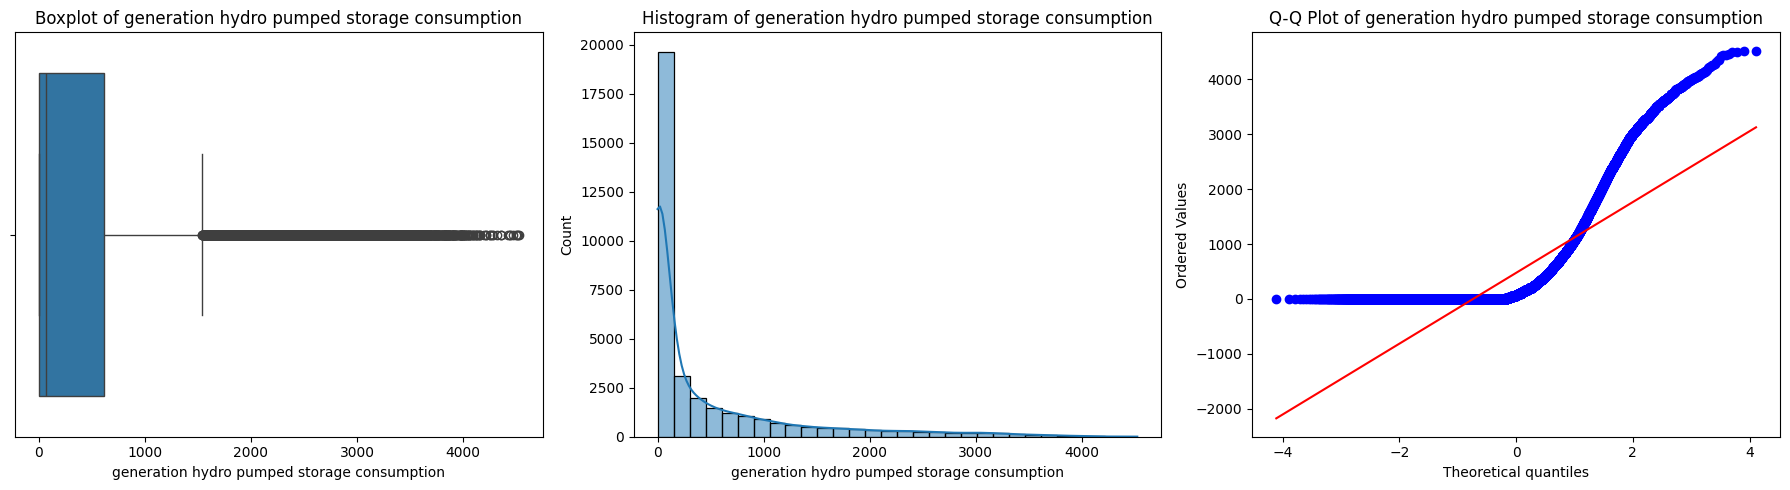

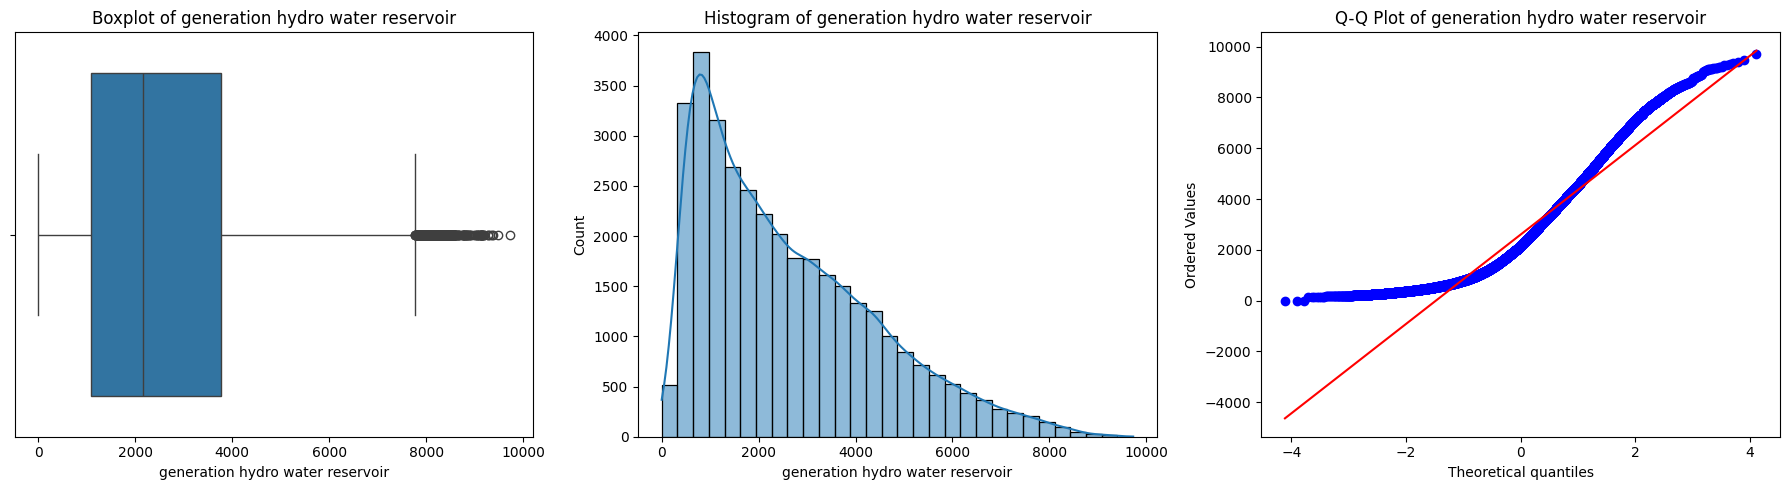

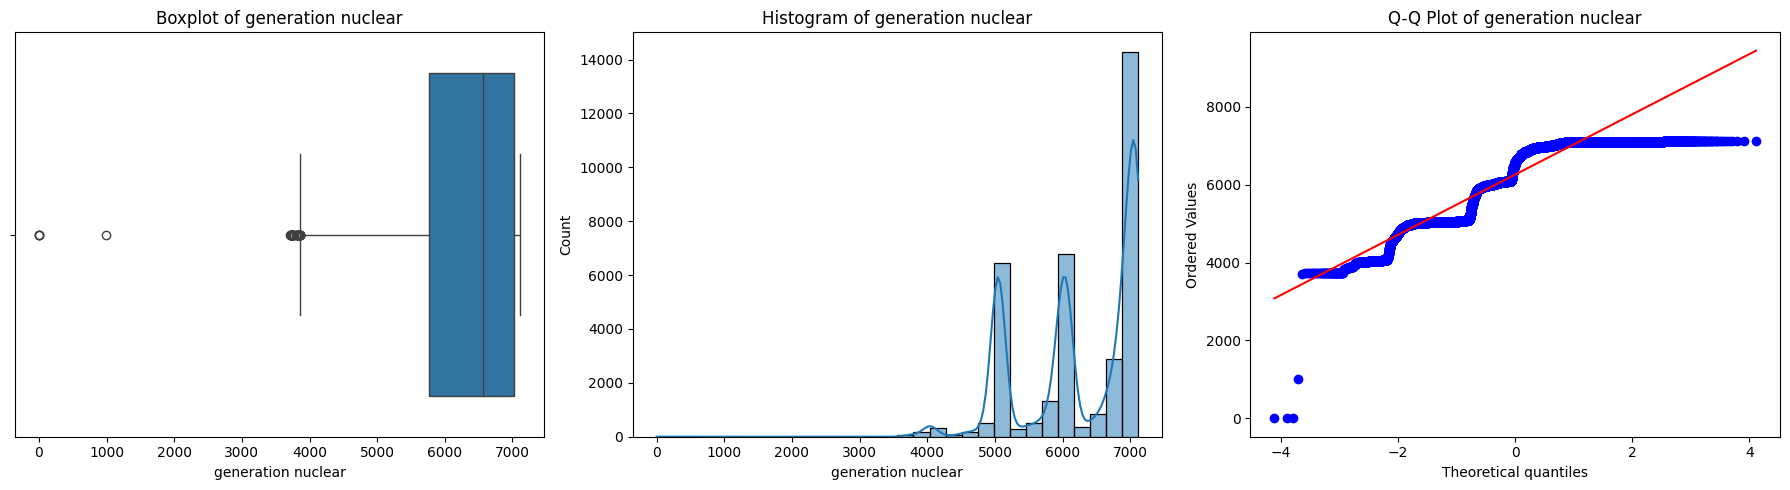

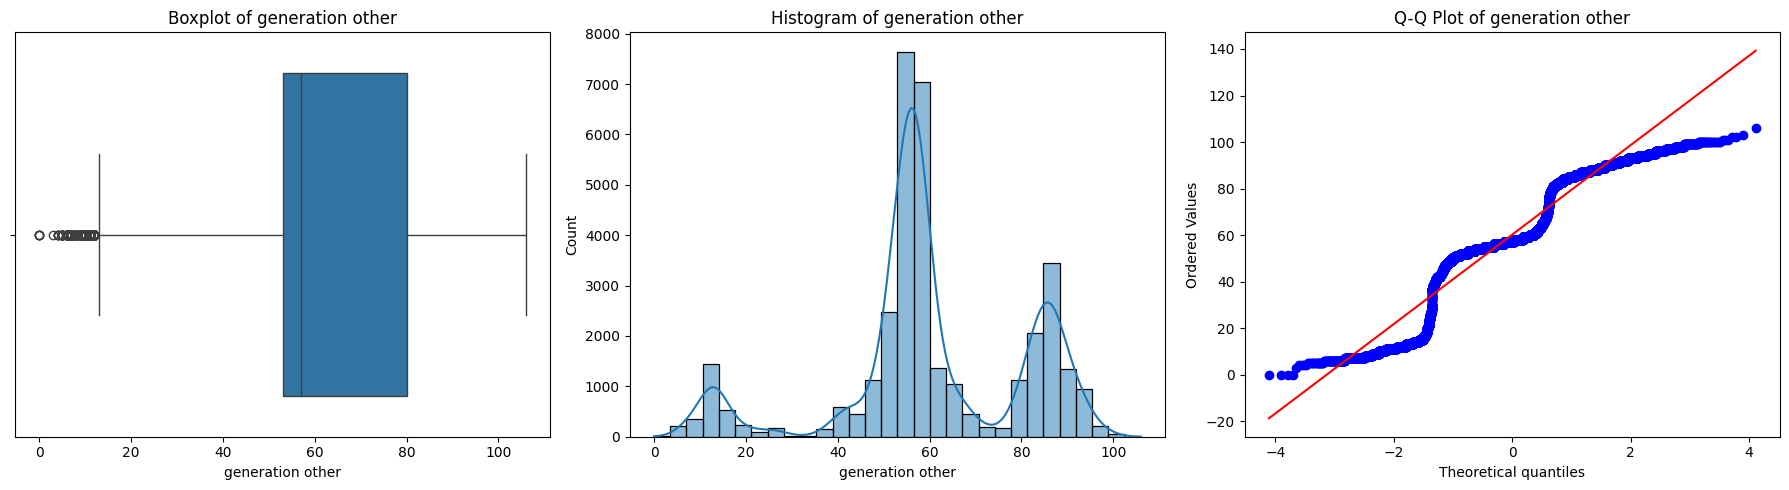

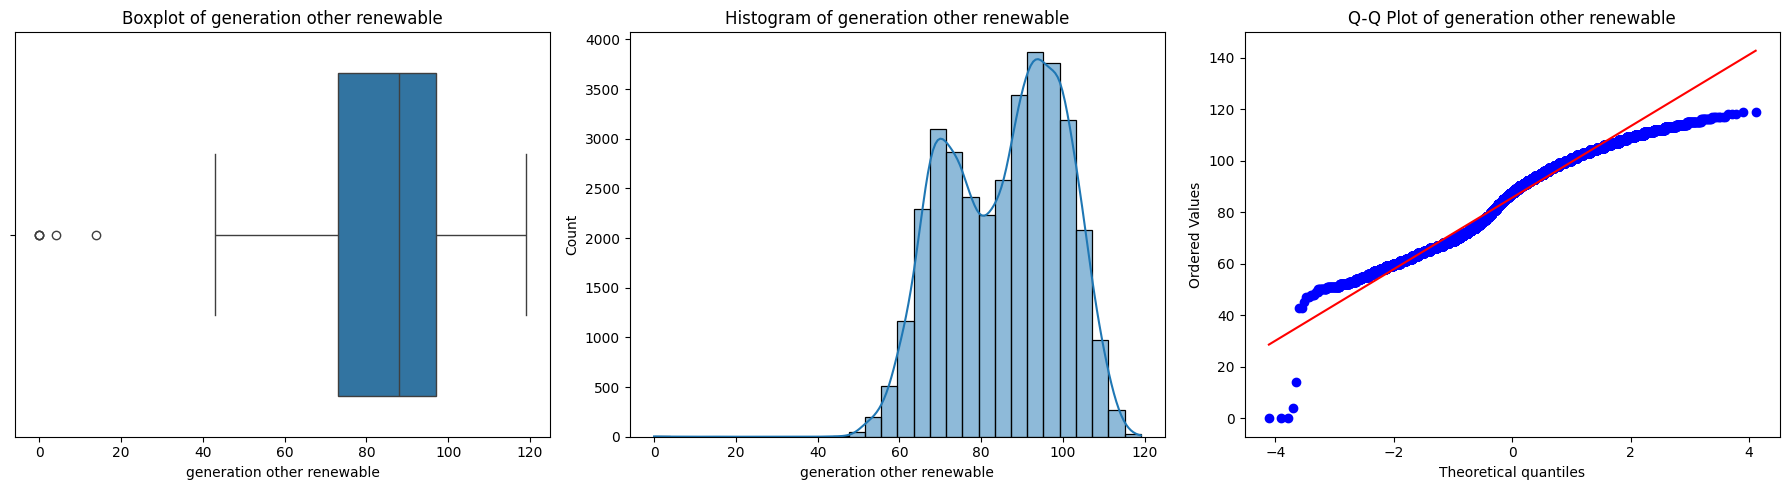

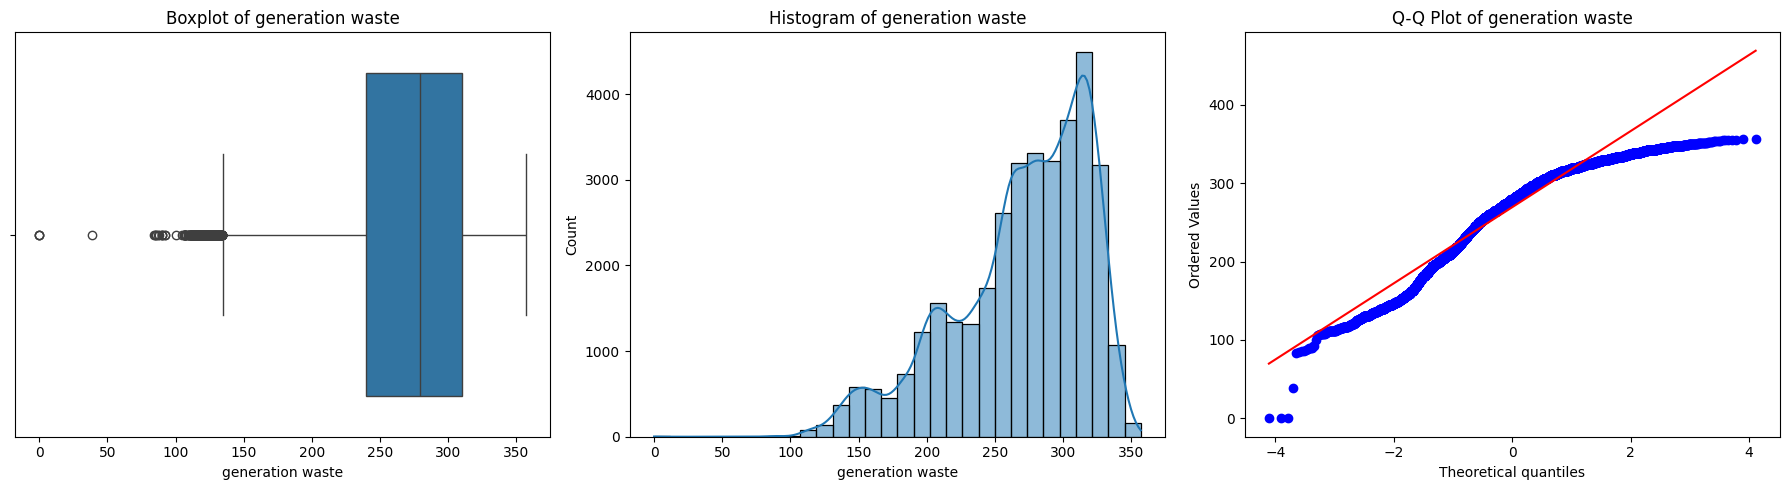

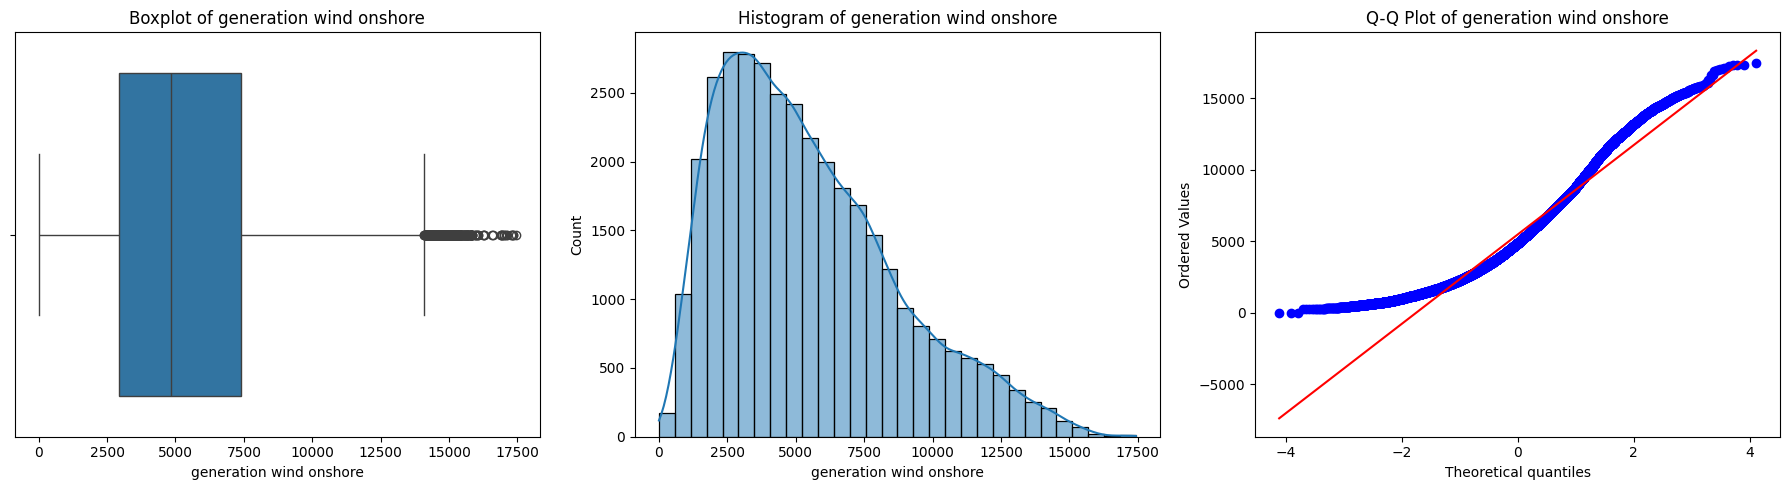

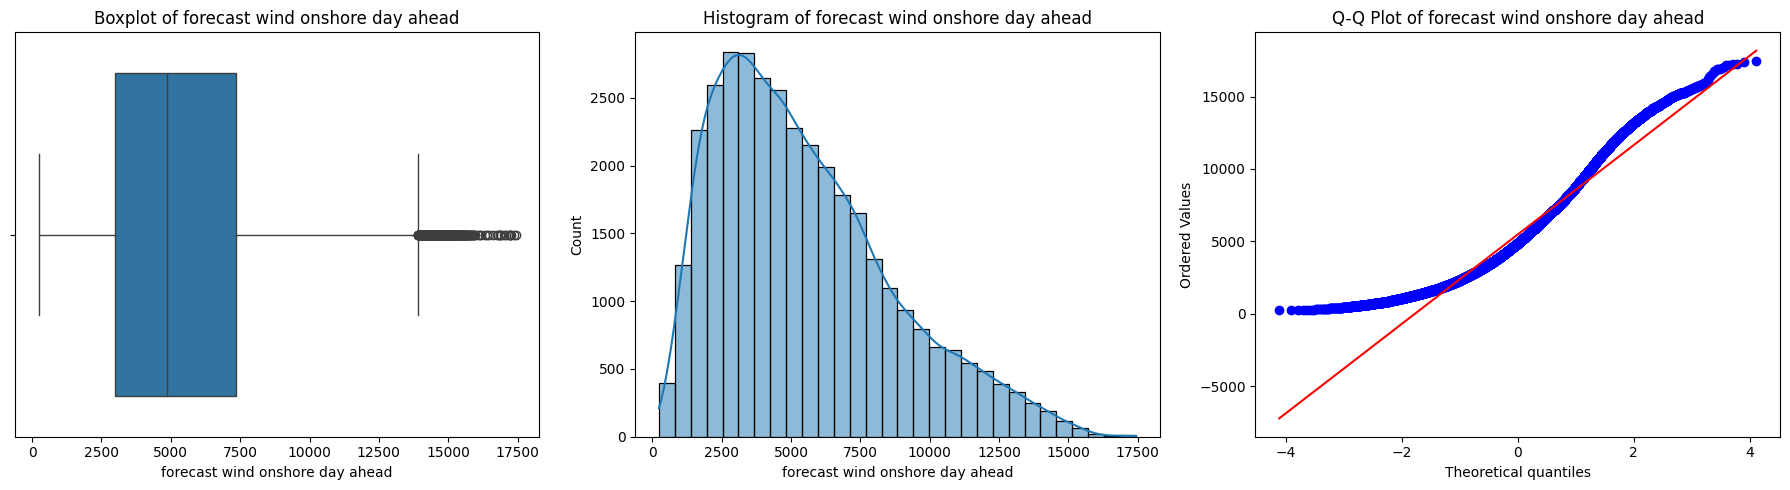

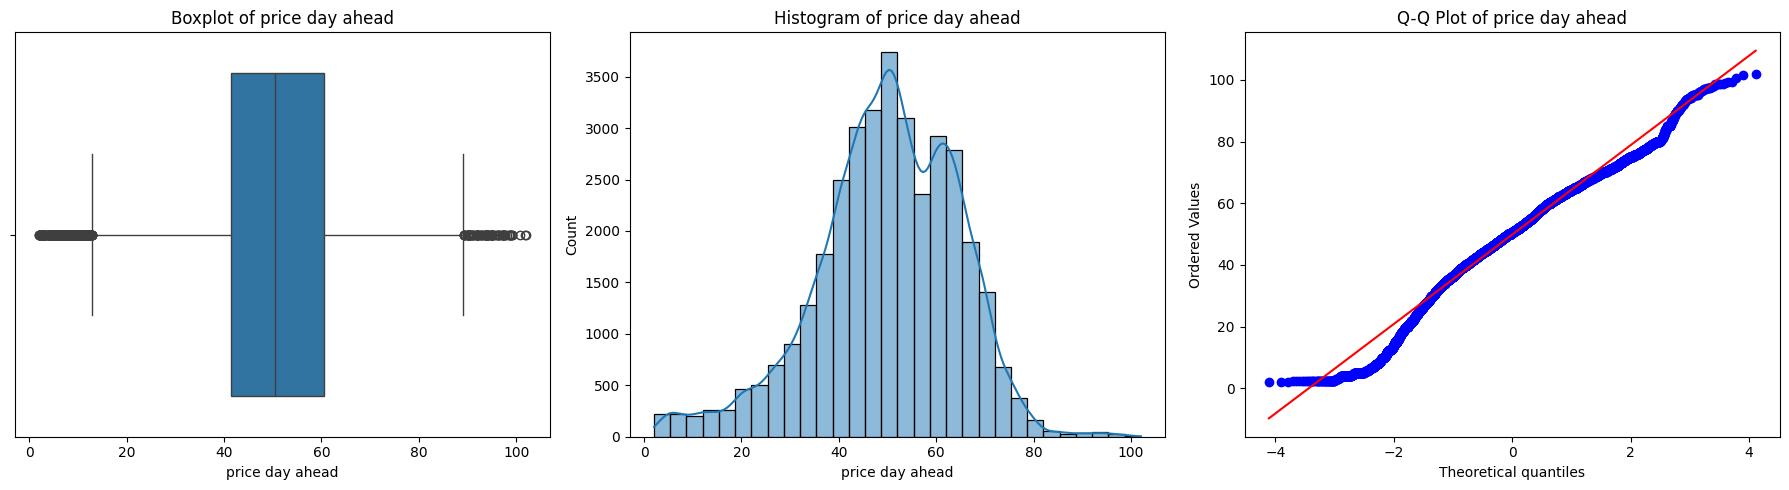

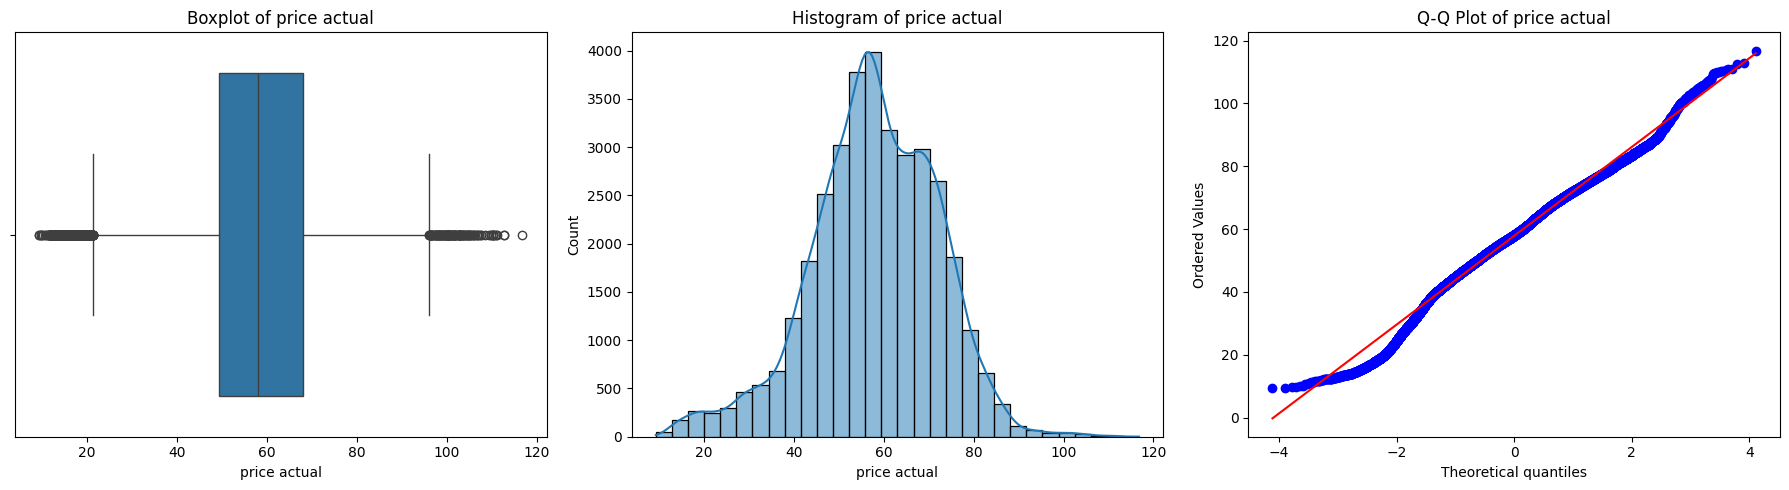

In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

energy_data = pd.read_csv('../data/energy_dataset.csv')  

numeric_energy_data = energy_data.select_dtypes(include=['number', 'float64'])

numeric_energy_data = numeric_energy_data.dropna(axis=1, how='all')

# Detect outliers using the IQR method
def detect_outliers(df):
    outliers = {}
    
    for column in df.columns:
        Q1 = df[column].quantile(0.25)  # First quartile (25th percentile)
        Q3 = df[column].quantile(0.75)  # Third quartile (75th percentile)
        IQR = Q3 - Q1  # Interquartile Range
        lower_bound = Q1 - 1.5 * IQR  # Lower bound for outliers
        upper_bound = Q3 + 1.5 * IQR  # Upper bound for outliers
        
        # Find outliers
        outlier_mask = (df[column] < lower_bound) | (df[column] > upper_bound)
        if outlier_mask.sum() > 0:  # Only keep columns that have outliers
            outliers[column] = df[column][outlier_mask]
            print(f"{column}: {outlier_mask.sum()} outliers detected")
    
    return outliers

# Call the outlier detection function
outliers = detect_outliers(numeric_energy_data)


# Plot figures only for columns that have outliers
for column in outliers.keys():  # Only iterate over columns with outliers
    # Create a new figure for each column
    plt.figure(figsize=(18, 5))
    
    # Plot 1: Boxplot
    plt.subplot(1, 3, 1)
    sns.boxplot(x=numeric_energy_data[column].dropna())
    plt.title(f'Boxplot of {column}')
    
    # Plot 2: Histogram
    plt.subplot(1, 3, 2)
    sns.histplot(numeric_energy_data[column].dropna(), kde=True, bins=30)
    plt.title(f'Histogram of {column}')
    
    # Plot 3: Q-Q Plot
    plt.subplot(1, 3, 3)
    stats.probplot(numeric_energy_data[column].dropna(), dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of {column}')
    
    # Display the plots for the current column
    plt.tight_layout()
    plt.show()


Skewness before transformation:
generation hydro pumped storage consumption    2.130588
generation fossil gas                          1.615447
generation other                              -0.506196
generation waste                              -0.849129
generation wind onshore                        0.785008
forecast wind onshore day ahead                0.800419
generation biomass                             0.421013
generation fossil oil                          0.064469
generation hydro water reservoir               0.897036
generation nuclear                            -0.691683
generation other renewable                    -0.216073
price day ahead                               -0.487771
price actual                                  -0.323749
dtype: float64

Skewness after transformation:
generation hydro pumped storage consumption   -0.001263
generation fossil gas                          0.187815
generation other                              -2.167481
generation waste         

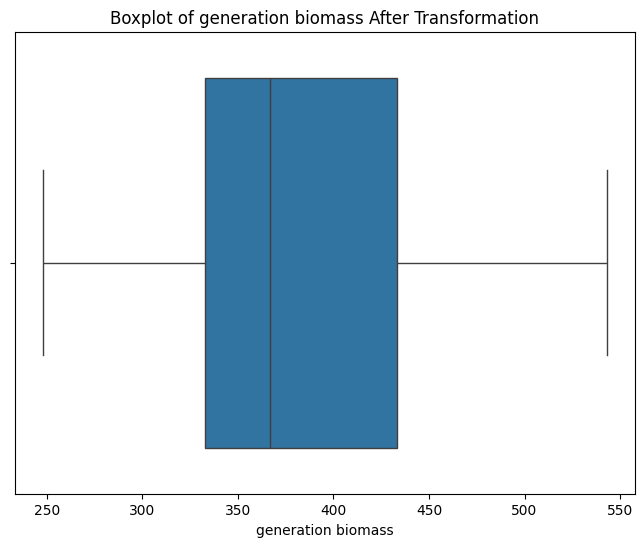

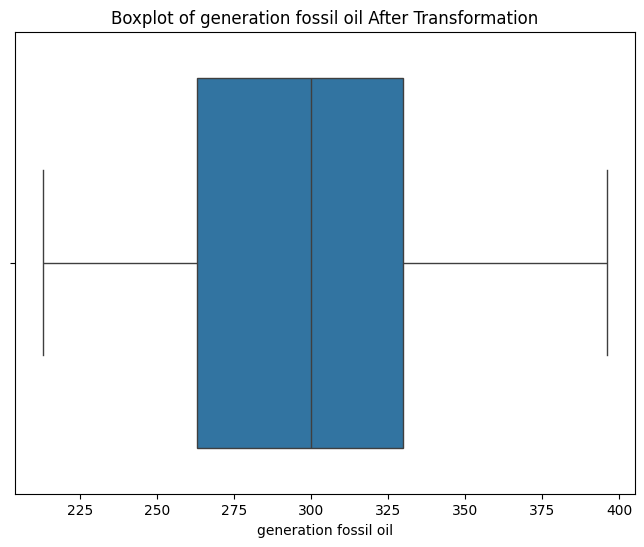

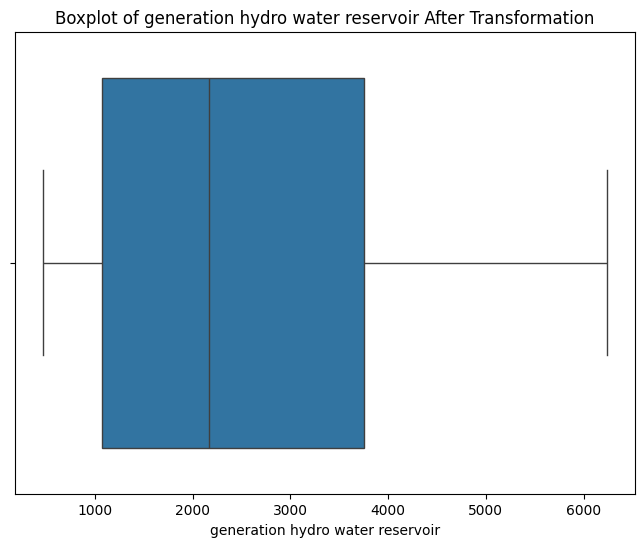

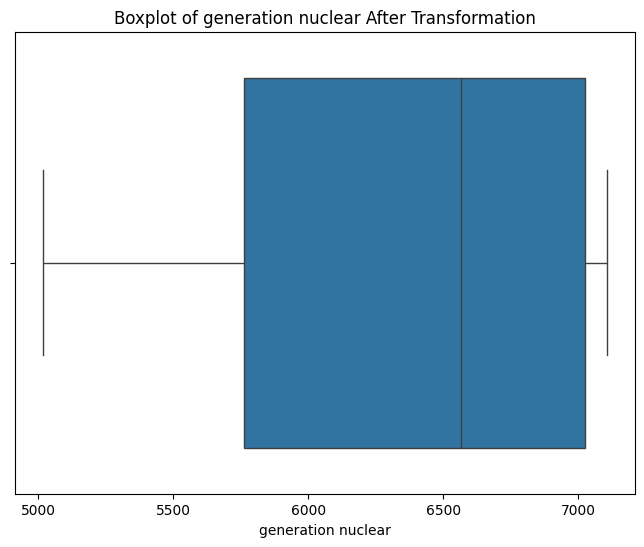

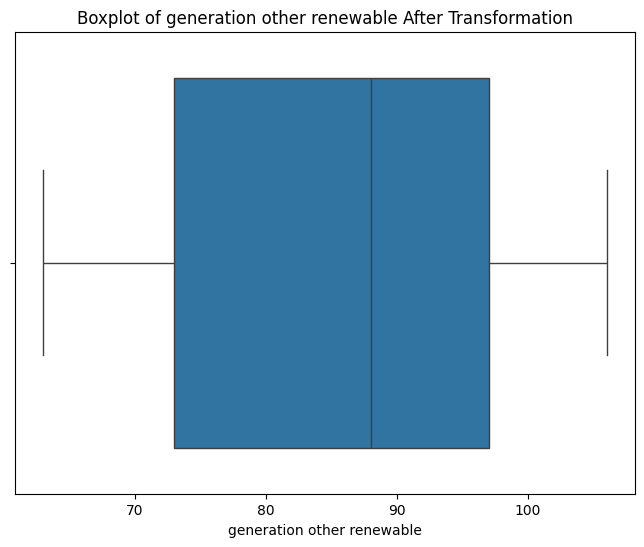

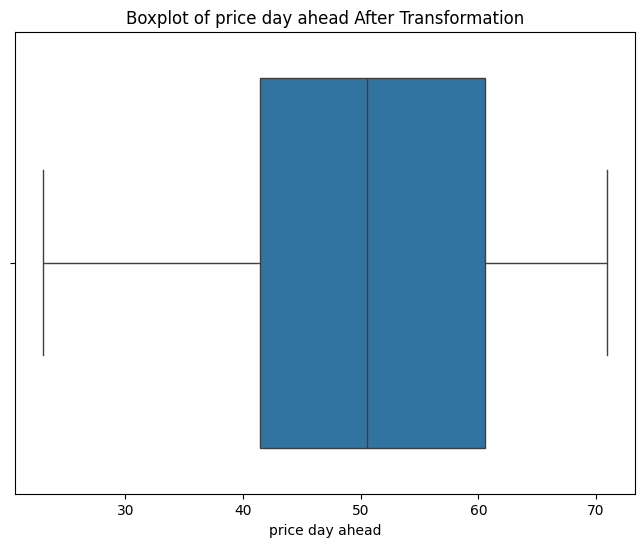

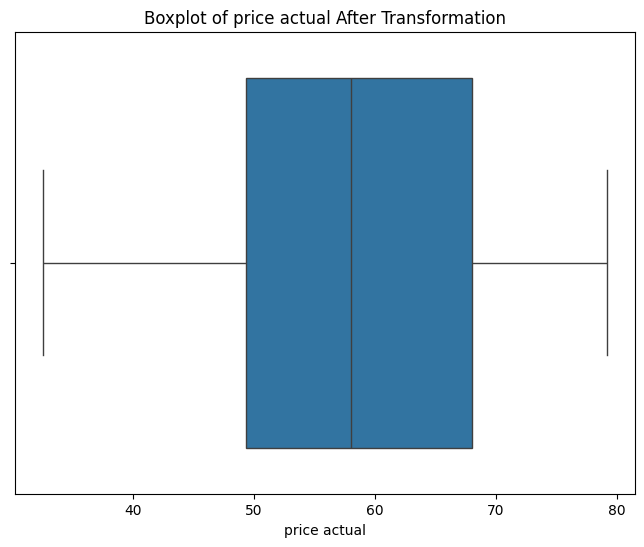

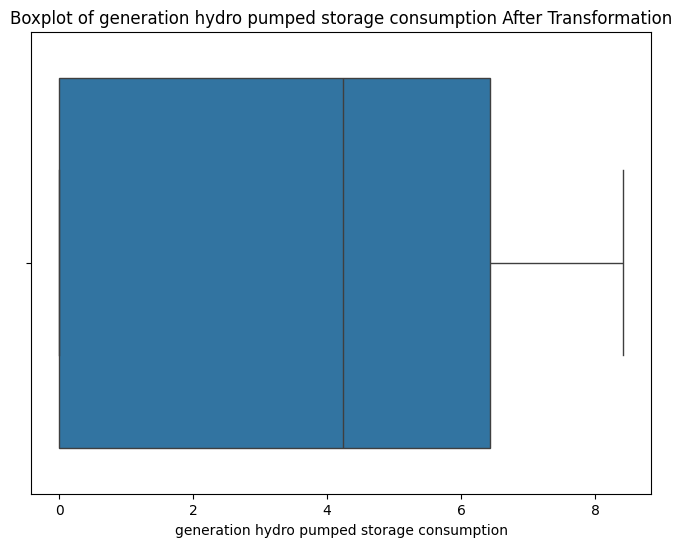

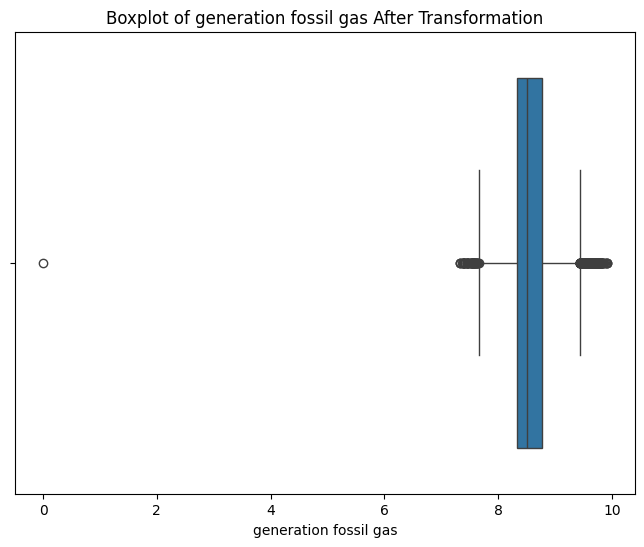

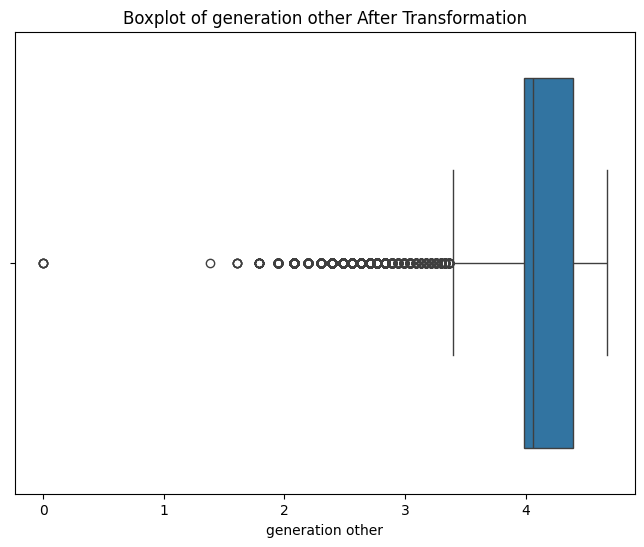

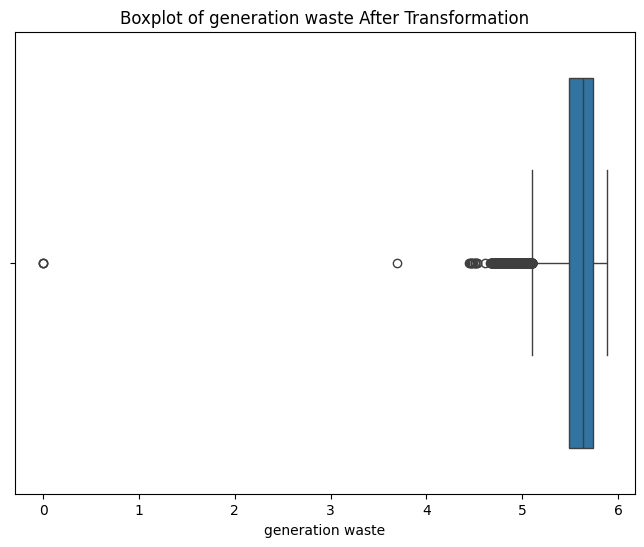

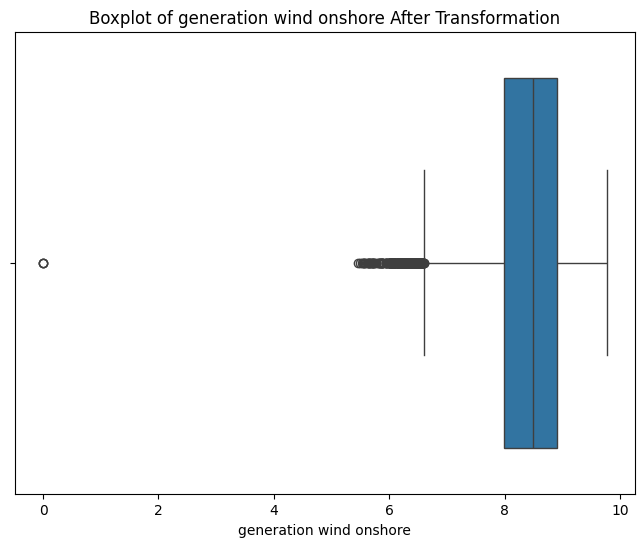

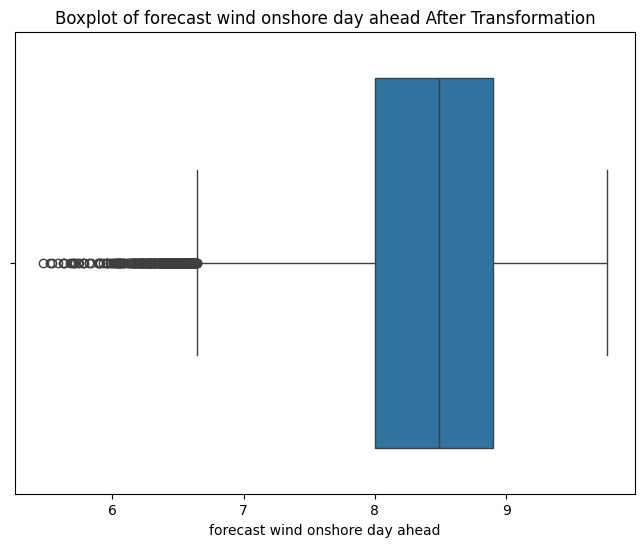

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Capping function based on the 5th and 95th percentiles
def cap_outliers(df, lower_percentile=0.05, upper_percentile=0.95):
    lower_bound = df.quantile(lower_percentile)
    upper_bound = df.quantile(upper_percentile)
    # Clip values to the percentile bounds
    df_capped = df.clip(lower=lower_bound, upper=upper_bound, axis=1)
    return df_capped

# Log transformation function
def log_transform(df):
    # Apply log transformation (adding 1 to avoid log(0))
    df_log_transformed = df.apply(lambda x: np.log1p(x))
    return df_log_transformed

# Function to apply transformations based on column-specific choices
def transform_columns(df, columns_to_cap, columns_to_log_transform):
    df_transformed = df.copy()
    
    # Apply capping to specified columns
    if columns_to_cap:
        df_transformed[columns_to_cap] = cap_outliers(df[columns_to_cap])
    
    # Apply log transformation to specified columns
    if columns_to_log_transform:
        df_transformed[columns_to_log_transform] = log_transform(df[columns_to_log_transform])
    
    return df_transformed


columns_to_log_transform = [
    'generation hydro pumped storage consumption', 'generation fossil gas', 'generation other', 
    'generation waste', 'generation wind onshore', 'forecast wind onshore day ahead'
]

columns_to_cap = [
    'generation biomass', 'generation fossil oil', 'generation hydro water reservoir', 
    'generation nuclear', 'generation other renewable', 
    'price day ahead', 'price actual'
]

print("Skewness before transformation:")
print(numeric_energy_data[columns_to_log_transform + columns_to_cap].skew())

transformed_energy_data = transform_columns(numeric_energy_data, columns_to_cap, columns_to_log_transform)

print("\nSkewness after transformation:")
print(transformed_energy_data[columns_to_log_transform + columns_to_cap].skew())

def visualize_transformed_data(df, transformed_columns):
    for column in transformed_columns:
        plt.figure(figsize=(8, 6))
        sns.boxplot(x=df[column].dropna())  
        plt.title(f'Boxplot of {column} After Transformation')
        plt.show()

visualize_transformed_data(transformed_energy_data, columns_to_cap)

visualize_transformed_data(transformed_energy_data, columns_to_log_transform)
